In [1]:
import json, glob, pycm, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from operator import itemgetter
from IPython.display import display, Markdown

In [2]:
def display_experiment(experiment):
    display(Markdown(f'## {experiment["concept"]["label"]} ({experiment["concept"]["id"]})'))
    display(Markdown(experiment["concept"]["definition"]))
    display(Markdown("### Confusion matrix"))
    cm = pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"])
    df_cm = pd.DataFrame(cm.matrix).T.fillna(0)
    ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
    ax.set_title(experiment["concept"]["label"])
    ax.set(xlabel='LLM', ylabel='KG')
    plt.show()
    df = pd.DataFrame.from_records(experiment["data"])
    df_fp = df[((df["actual"] == 'negative') & (df["predicted"] == 'positive'))][["label", "description", "rationale"]]
    if len(df_fp) > 0:
        df_fp_styler = df_fp.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown("### LLM positive, KG negative"))
        display(df_fp_styler)
    df_fn = df[((df["actual"] == 'positive') & (df["predicted"] == 'negative'))][["label", "description", "rationale"]]
    if len(df_fn) > 0:
        df_fn_styler = df_fn.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown("### LLM negative, KG positive"))
        display(df_fn_styler)

In [3]:
experiments = [ experiment for experiment in json.load(open('../experiments/wd_gpt-4_serialization_from_wikidata_results.json', 'r')) if "confusion_matrix" in experiment ]

In [4]:
for experiment in experiments:
    ids = {}
    data = []
    for entity in experiment["data"]:
        if entity['id'] in ids:
            print("Duplicate:", entity['id'])
        else:
            ids[entity['id']] = 1
            data.append(entity)
    experiment["data"] = data
    df_results = pd.DataFrame.from_records(data)
    cm = pycm.ConfusionMatrix(df_results["actual"].tolist(), df_results["predicted"].tolist(), digit=2, classes=[ 'positive', 'negative' ])
    experiment["confusion_matrix"] = cm.matrix

Duplicate: http://www.wikidata.org/entity/Q43236683
Duplicate: http://www.wikidata.org/entity/Q43236683
Duplicate: http://www.wikidata.org/entity/Q43236683


In [9]:
experiment_df = pd.DataFrame.from_records([ 
    { 
        "name": experiment["concept"]['label'], 
        "kappa": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Kappa,
        "SOA9": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).SOA9,
        "ACC": f'{pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Overall_ACC:.1%}',
        "AUC": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).AUC['positive'],
        "F1": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).F1_Macro,
        "FP": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).FP["positive"],
        "FN": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).FN["positive"],
        "POP": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).POP["positive"],
        "experiment": experiment,
    }
    for experiment in experiments ]).sort_values("kappa", ascending=False)
experiment_df[["name", "kappa", "SOA9", "ACC", "F1", "AUC", "FP", "FN", "POP"]]

,name,kappa,SOA9,ACC,F1,AUC,FP,FN,POP
10,Cities of Japan,1.000000,High,100.0%,1.000000,1.000000,0,0,40
5,Equestrian sport,1.000000,High,100.0%,1.000000,1.000000,0,0,40
14,Art movement,1.000000,High,100.0%,1.000000,1.000000,0,0,40
1,Embedded system,0.900000,High,95.0%,0.949875,0.950000,0,2,40
16,Chronology,0.900000,High,95.0%,0.949875,0.950000,0,2,40
12,Village (Japan),0.900000,High,95.0%,0.949875,0.950000,0,2,40
13,Fetus,0.897638,High,94.9%,0.948684,0.950000,0,2,39
17,Indigenous peoples of the Americas,0.846255,High,92.3%,0.923077,0.923684,1,2,39
18,Esports,0.800000,High,90.0%,0.898990,0.900000,0,4,40
0,History of cities,0.700000,Tentative,85.0%,0.846547,0.850000,6,0,40


In [10]:
experiment_df.describe()

,kappa,AUC,F1,FP,FN,POP
count,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000
mean,0.644276,0.822303,0.803520,1.10000,6.000000,39.850000
std,0.309719,0.154916,0.186990,2.38195,5.964809,0.366348
min,0.000000,0.500000,0.333333,0.00000,0.000000,39.000000
25%,0.375000,0.687500,0.664363,0.00000,2.000000,40.000000
50%,0.700000,0.850000,0.846547,0.00000,4.500000,40.000000
75%,0.900000,0.950000,0.949875,1.00000,8.250000,40.000000
max,1.000000,1.000000,1.000000,9.00000,20.000000,40.000000


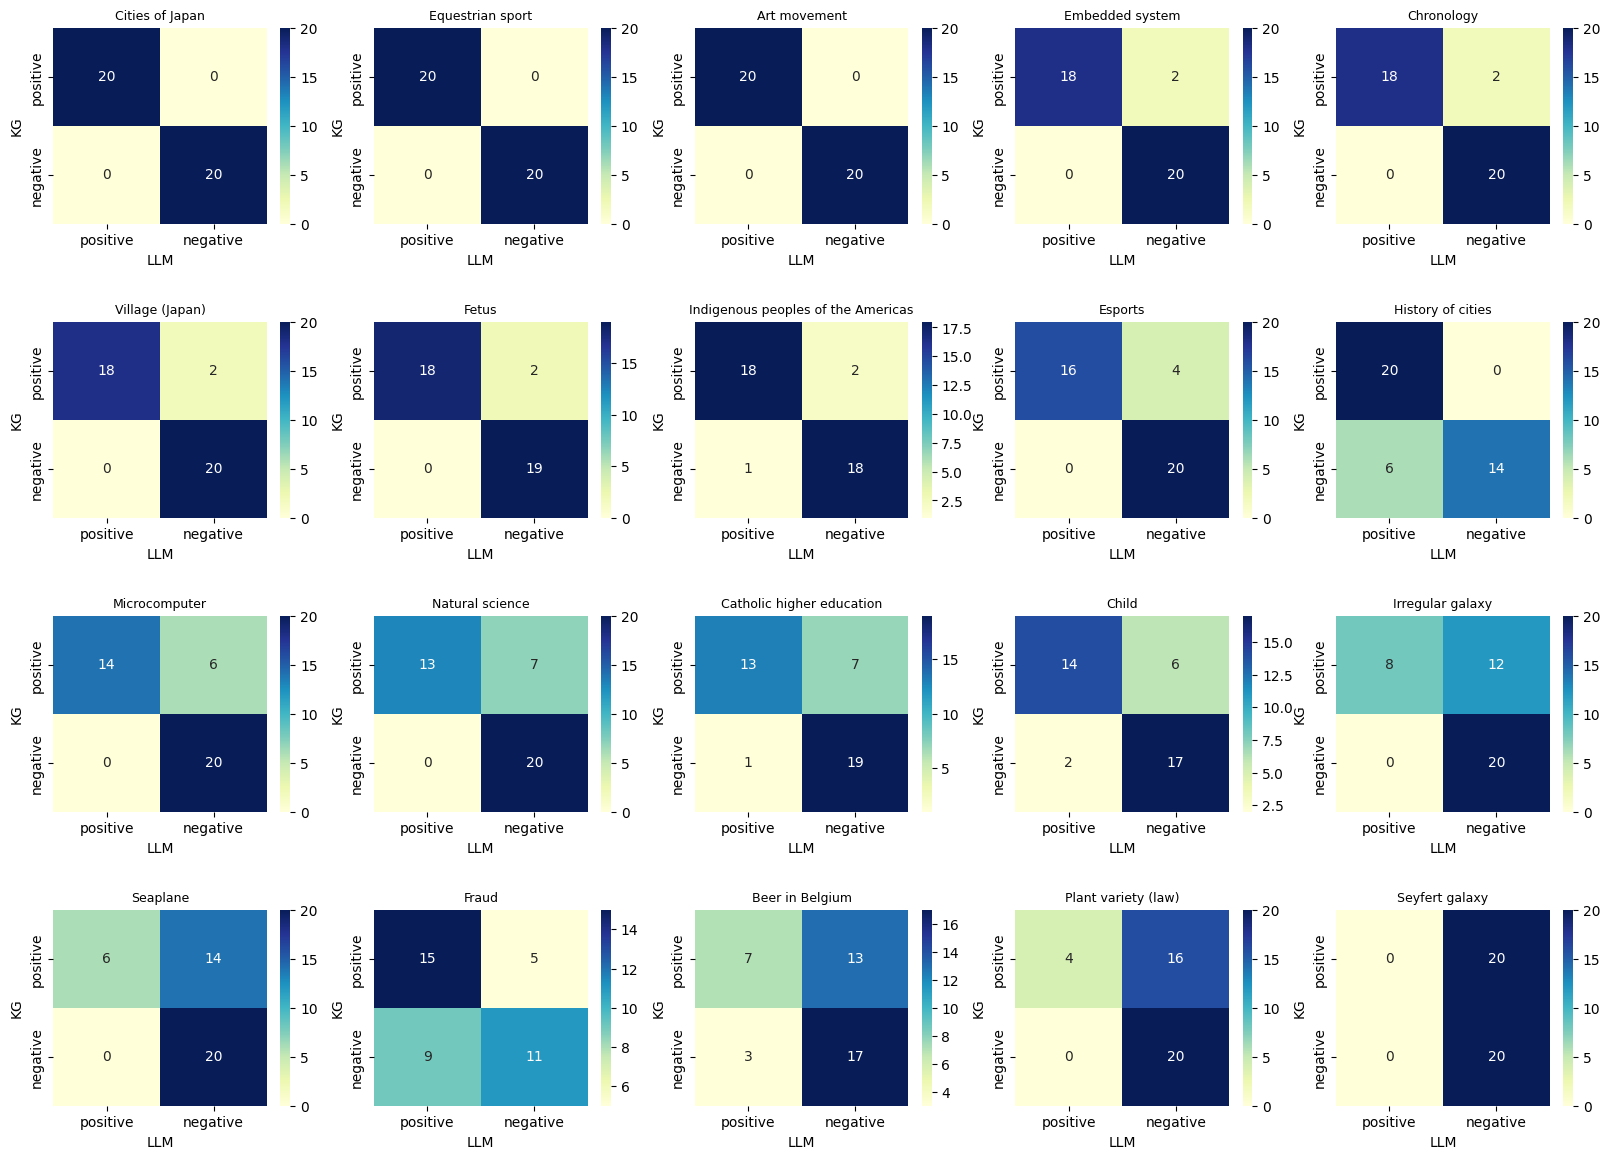

In [7]:
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4, 5, hspace=0.5)
axes = gs.subplots()
cms = [ (experiment["name"], pycm.ConfusionMatrix(matrix=experiment["experiment"]["confusion_matrix"])) for experiment in experiment_df.to_dict('records')  ]
for ax, (name, cm) in zip(axes.flat, cms):
    df = pd.DataFrame(cm.matrix).T.fillna(0)
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
    ax.set_title(name, wrap=True, fontsize=9)
    ax.set(xlabel='LLM', ylabel='KG')
for ax in axes.flat[len(cms):]:
    ax.set_visible(False)
plt.show()

## Cities of Japan (http://www.wikidata.org/entity/Q494721)

Cities of Japan: A city (市, shi) is a local administrative unit in Japan. Cities are ranked on the same level as towns (町, machi) and villages (村, mura), with the difference that they are not a component of districts (郡, gun). Like other contemporary administrative units, they are defined by the Local Autonomy Law of 1947.

### Confusion matrix

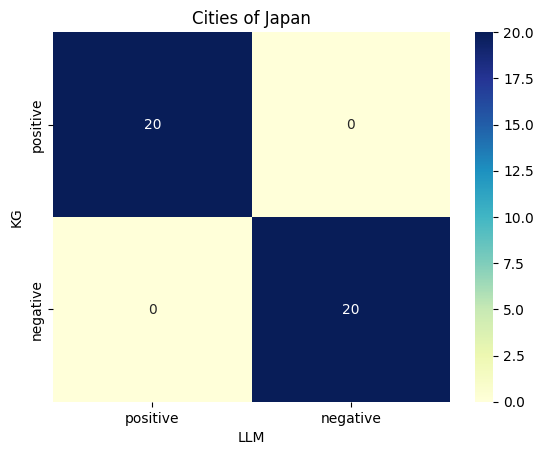

## Equestrian sport (http://www.wikidata.org/entity/Q902378)

Equestrian sport: Equestrian sports are sports that use horses as a main part of the sport. This usually takes the form of the rider being on the horse's back, or the horses pulling some sort of horse-drawn vehicle.

### Confusion matrix

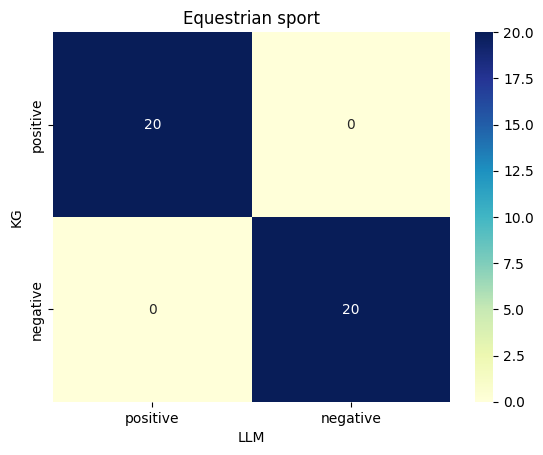

## Art movement (http://www.wikidata.org/entity/Q968159)

Art movement: An art movement is a tendency or style in art with a specific common philosophy or goal, followed by a group of artists during a specific period of time, (usually a few months, years or decades) or, at least, with the heyday of the movement defined within a number of years. Art movements were especially important in modern art, when each consecutive movement was considered a new avant-garde movement. Western art had been, from the Renaissance up to the middle of the 19th century, underpinned by the logic of perspective and an attempt to reproduce an illusion of visible reality (figurative art). By the end of the 19th century many artists felt a need to create a new style which would encompass the fundamental changes taking place in technology, science and philosophy (abstract art).



### Confusion matrix

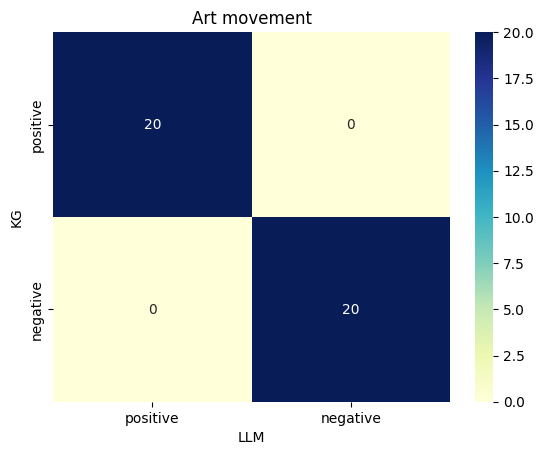

## Embedded system (http://www.wikidata.org/entity/Q193040)

Embedded system: An embedded system is a computer system—a combination of a computer processor, computer memory, and input/output peripheral devices—that has a dedicated function within a larger mechanical or electronic system. It is embedded as part of a complete device often including electrical or electronic hardware and mechanical parts. 
Because an embedded system typically controls physical operations of the machine that it is embedded within, it often has real-time computing constraints.  Embedded systems control many devices in common use. In 2009, it was estimated that ninety-eight percent of all microprocessors manufactured were used in embedded systems.Modern embedded systems are often based on microcontrollers (i.e. microprocessors with integrated memory and peripheral interfaces), but ordinary microprocessors (using external chips for memory and peripheral interface circuits) are also common, especially in more complex systems. In either case, the processor(s) used may be types ranging from general purpose to those specialized in a certain class of computations, or even custom designed for the application at hand. A common standard class of dedicated processors is the digital signal processor (DSP).
Since the embedded system is dedicated to specific tasks, design engineers can optimize it to reduce the size and cost of the product and increase its reliability and performance. Some embedded systems are mass-produced, benefiting from economies of scale.
Embedded systems range in size from portable personal devices such as digital watches and MP3 players to bigger machines like home appliances, industrial assembly lines, robots, transport vehicles, traffic light controllers, and medical imaging systems. Often they constitute subsystems of other machines like avionics in aircraft and astrionics in spacecraft. Large installations like factories, pipelines and electrical grids rely on multiple embedded systems networked together. Generalized through software customization, embedded systems such as programmable logic controllers frequently comprise their functional units.
Embedded systems range from those low in complexity, with a single microcontroller chip, to very high with multiple units, peripherals and networks, which may reside in equipment racks or across large geographical areas connected via long-distance communications lines.



### Confusion matrix

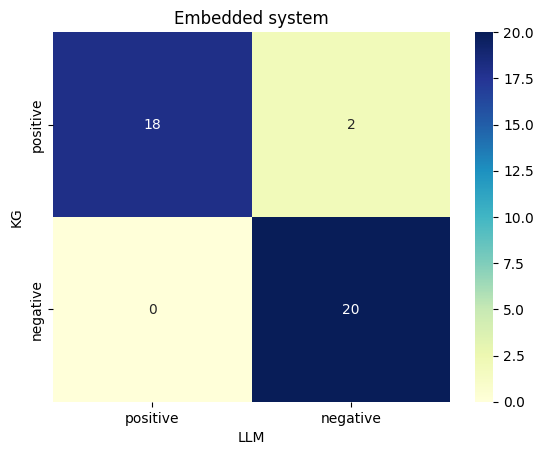

### LLM negative, KG positive

label,description,rationale
Namco Warp & Warp,"Namco Warp & Warp: Namco was a video game developer and publisher, originally from Japan. Bandai Namco Entertainment is the successor to Namco and continues manufacturing and distributing video games worldwide. For Namco games released following the 2006 merger with Bandai's video game division, see List of Bandai Namco video games. For a list of franchises owned by Bandai Namco, see List of Bandai Namco video game franchises.","Without additional information specifically linking Namco Warp & Warp to the definition of an embedded system, it's not possible to definitively argue that Namco Warp & Warp is an embedded system. The definition provided describes an embedded system as a computer system with a dedicated function within a larger mechanical or electrical system. While Namco Warp & Warp could potentially utilize embedded systems in its operation, the provided information does not confirm this. Therefore, based on the given information, we cannot assert that Namco Warp & Warp is an embedded system."
Naomi 2,Naomi 2,"The definition of an embedded system is a computer system with a dedicated function within a larger mechanical or electrical system. While the provided description for Naomi 2 is not detailed, it is known to be a specific entity, which suggests it could be a system with a dedicated function. Therefore, it could be argued that Naomi 2 is an embedded system. However, without more specific information about Naomi 2's functions and its role within a larger system, this assertion cannot be definitively confirmed."


## Chronology (http://www.wikidata.org/entity/Q130788)

Chronology: Chronology (from Latin chronologia, from Ancient Greek χρόνος, chrónos, \"time\"; and -λογία, -logia) is the science of arranging events in their order of occurrence in time. Consider, for example, the use of a timeline or sequence of events. It is also \"the determination of the actual temporal sequence of past events\".Chronology is a part of periodization. It is also a part of the discipline of history including earth history, the earth sciences, and study of the geologic time scale.

### Confusion matrix

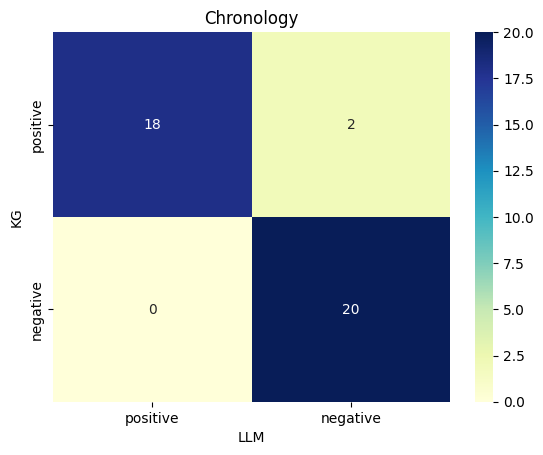

### LLM negative, KG positive

label,description,rationale
MUL.APIN,"MUL.APIN: MUL.APIN (𒀯𒀳) is the conventional title given to a Babylonian compendium that deals with many diverse aspects of Babylonian astronomy and astrology. It is in the tradition of earlier star catalogues, the so-called Three Stars Each lists, but represents an expanded version based on more accurate observation, likely compiled around 1000 BCE. The text lists the names of 66 stars and constellations and further gives a number of indications, such as rising, setting and culmination dates, that help to map out the basic structure of the Babylonian star map. The text is preserved in a 7th-century BCE copy on a pair of tablets, named for their incipit, corresponding to the first constellation of the year, MULAPIN \""The Plough\"", identified with stars in the area of the modern constellations of Cassiopeia, Andromeda and Triangulum according to the compilation of suggestions by Gössmann and Kurtik. Recently, it has been suggested to identify with Cassiopeia only.","The MUL.APIN, as described, is a compendium with many diverse aspects of Babylonian astronomy and astrology. This suggests that it contains a collection of events or phenomena related to astronomy and astrology, possibly arranged in a certain order. Chronology, as defined, is the science of arranging events in order of occurrence. Therefore, if the events or phenomena in the MUL.APIN are arranged in the order of their occurrence or discovery, it could be considered a form of chronology."
Malanka,"Malanka: Malanka (Ukrainian: Маланка, or Ukrainian: Щедрий Вечір, romanized: Shchedryi Vechir, lit. 'bounteous evening') is a Ukrainian folk holiday celebrated on 13 January, which is New Year's Eve in accordance with the 31 December of Julian calendar (see Old New Year). The festivities were historically centred around house-to-house visiting by groups of young men, costumed as characters from a folk tale of pre-Christian origin, as well as special food and drink. The context of the rituals has changed, but some elements continue to the present.","The assertion that Malanka is a Chronology cannot be supported based on the given definitions. Chronology is defined as the science of arranging events in order of occurrence. Malanka, on the other hand, is described as a folk holiday of Eastern Slavs celebrated on New Year's Eve. There is no information provided that suggests Malanka involves arranging events in order of occurrence, which is the key characteristic of a chronology. Therefore, based on the provided definitions, Malanka cannot be classified as a chronology."


## Village (Japan) (http://www.wikidata.org/entity/Q4174776)

Village (Japan): A village (村, mura) is a local administrative unit in Japan.
It is a local public body along with prefecture (県, ken, or other equivalents), city (市, shi), and town (町, chō, sometimes machi). Geographically, a village's extent is contained within a prefecture.
It is larger than an actual settlement, being in actuality a subdivision of a rural district (郡, gun), which are subdivided into towns and villages with no overlap and no uncovered area.
As a result of mergers and elevation to higher statuses, the number of villages in Japan is decreasing.
As of 2006, 13 prefectures no longer have any villages: Tochigi (since March 20, 2006), Fukui (since March 3, 2006), Ishikawa (since March 1, 2005), Shizuoka (since July 1, 2005), Hyōgo (since April 1, 1999), Mie (since November 1, 2005), Shiga (since January 1, 2005), Hiroshima (since November 5, 2004), Yamaguchi (since March 20, 2006), Ehime (since January 16, 2005), Kagawa (since April 1, 1999), Nagasaki (since October 1, 2005), and Saga (since March 20, 2006).
Atarashiki-mura (which is an autonomous village community) is not included in the list below.



### Confusion matrix

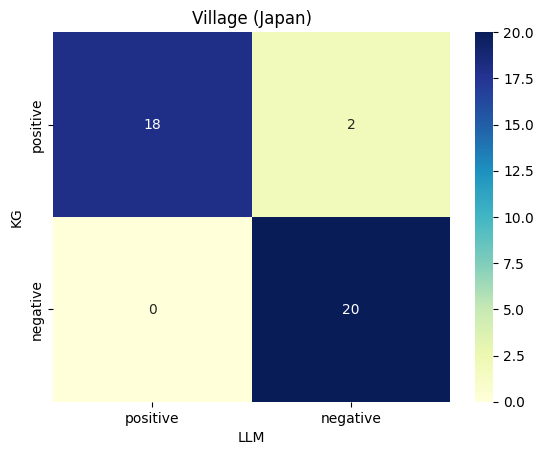

### LLM negative, KG positive

label,description,rationale
Shibetoro,Shibetoro,"The assertion that Shibetoro is a Village (Japan) cannot be supported based on the provided definitions. The description of Shibetoro identifies it as a ""former village in Kurilsky District, Sakhalin Oblast, Russia"", not as a local administrative unit in Japan. Therefore, based on the given information, Shibetoro does not fit the definition of a Village (Japan)."
Tachikawa,"Tachikawa: Tachikawa (立川市, Tachikawa-shi) is a city located in the western portion of Tokyo Metropolis, Japan. As of 1 March 2021, the city had an estimated population of 184,383 in 93,428 households, and a population density of 7600 persons per km2. The total area of the city is 24.36 square kilometres (9.41 sq mi).","Based on the provided definitions, it is not possible to argue that Tachikawa is a Village (Japan). The definition of Tachikawa indicates that it is a ""city in Tokyo, Japan"". The definition of Village (Japan) is a ""local administrative unit in Japan"". There is no information provided that suggests a city can also be considered a village in the context of Japan's administrative units. Therefore, without additional information, we cannot assert that Tachikawa is a Village (Japan)."


## Fetus (http://www.wikidata.org/entity/Q26513)

Fetus: A fetus or foetus (; PL: fetuses, feti, foetuses, or foeti) is the unborn offspring that develops from an animal embryo. Following embryonic development the fetal stage of development takes place. In human prenatal development, fetal development begins from the ninth week after fertilization (or eleventh week gestational age) and continues until birth. Prenatal development is a continuum, with no clear defining feature distinguishing an embryo from a fetus. However, a fetus is characterized by the presence of all the major body organs, though they will not yet be fully developed and functional and some not yet situated in their final anatomical location.

### Confusion matrix

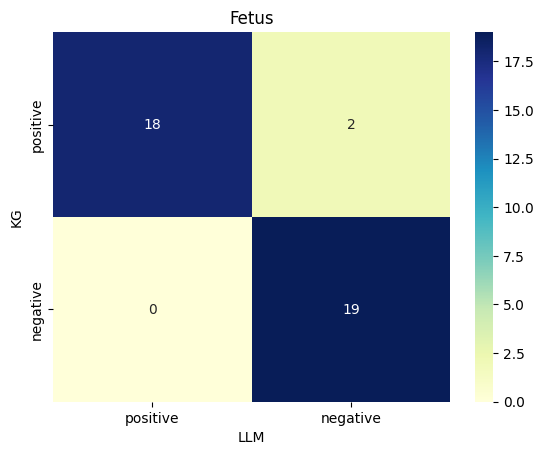

### LLM negative, KG positive

label,description,rationale
"Luísa Vitória, Princess of Grão-Pará","Luísa Vitória, Princess of Grão-Pará","The definition provided for a fetus is a ""prenatal human between the embryonic state and birth"". However, there is no information given in the description of Luísa Vitória, Princess of Grão-Pará that indicates she was in a prenatal state, between the embryonic state and birth. Therefore, based solely on the provided definitions, there is no valid argument to assert that Luísa Vitória, Princess of Grão-Pará is a fetus."
Paul Richard Polanski,Paul Richard Polanski,"The definition of a fetus is a ""prenatal human between the embryonic state and birth"". Paul Richard Polanski, being the son of Sharon Tate and Roman Polanski, must have been a prenatal human between the embryonic state and birth at some point in time. Therefore, it can be argued that Paul Richard Polanski was a fetus."


## Indigenous peoples of the Americas (http://www.wikidata.org/entity/Q36747)

Indigenous peoples of the Americas: The Indigenous peoples of the Americas are the original inhabitants of the Western Hemisphere, and have occupied the Americas since prior to European colonization of the Americas. They are a diverse group of peoples, with a wide range of cultures, languages, and ways of life.
Some Indigenous peoples in the Americas have historically been hunter-gatherers, while others traditionally practice agriculture and aquaculture. In the Amazon basin in present-day South America, some Indigenous peoples still live as hunter-gatherers while those in other regions may maintain their traditional lifestyles to a lesser extent.Some Indigenous peoples have traditionally depended heavily on agriculture, and others on a mix of farming, hunting, and gathering. In some regions, Indigenous peoples have created pre-contact monumental architecture, large-scale organized cities, city-states, chiefdoms, states, kingdoms, republics, confederacies, and empires. These societies have had varying degrees of knowledge of engineering, architecture, mathematics, astronomy, writing, physics, medicine, planting and irrigation, geology, mining, metallurgy, sculpture, and gold smithing.
Many parts of the Americas are still populated by Indigenous peoples; some countries have sizeable populations, especially Bolivia, Canada, Chile, Ecuador, Guatemala, Mexico, Peru, and the United States. At least a thousand different Indigenous languages are spoken in the Americas, where there are also 574 federally recognized tribes in the United States alone. Several of these languages are recognized as official by several governments such as those in Bolivia, Peru, Paraguay and Greenland. Some, such as Quechua, Arawak, Aymara, Guaraní, Mayan, and Nahuatl, count their speakers in the millions. Whether contemporary Indigenous people live in rural communities or urban ones, many also maintain additional aspects of their cultural practices to varying degrees, including religion, social organization, and subsistence practices. Like most cultures, over time, cultures specific to many Indigenous peoples have also evolved, preserving traditional customs but also adjusting to meet modern needs. Some Indigenous peoples still live in relative isolation from Western culture and a few are still counted as uncontacted peoples.



### Confusion matrix

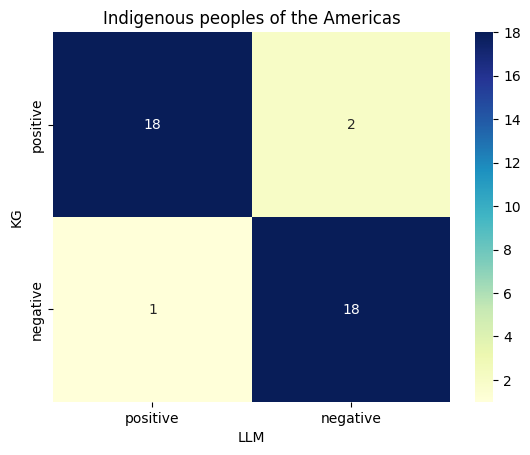

### LLM positive, KG negative

label,description,rationale
Basawi,Basawi,"The description of Basawi indicates that she is an ""Indian woman."" The term ""Indian"" is often used to refer to Indigenous peoples of the Americas, as indicated by the alternate labels ""American Indians"" and ""Amerindians"" in the definition of Indigenous peoples of the Americas. Therefore, based on this information, it can be argued that Basawi is a part of the Indigenous peoples of the Americas."


### LLM negative, KG positive

label,description,rationale
Hamatla Treaty Society,Hamatla Treaty Society: The Hamatla Treaty Society handles Treaty negotiations in the BC Treaty Process for a number of First Nations located in the northern Strait of Georgia of British Columbia.,"The provided definition does not give enough information to definitively argue that the Hamatla Treaty Society is a part of the Indigenous peoples of the Americas. The definition only provides alternative labels for the concept of Indigenous peoples of the Americas, such as ""Amerindians"", ""indigenous Americans"", ""Native Americans"", and ""American Indians"". However, it does not provide any characteristics, attributes, or defining features of these groups. Similarly, the description of the Hamatla Treaty Society is simply its label, with no additional information about its nature, purpose, or affiliations. Therefore, based solely on the provided definitions, it is not possible to argue that the Hamatla Treaty Society is a part of the Indigenous peoples of the Americas."
Bamoa,Bamoa,"The provided definition does not give any information that could be used to argue that Bamoa, a human settlement in Mexico, is an Indigenous peoples of the Americas. The definition of Indigenous peoples of the Americas includes terms like ""Amerindians"", ""indigenous Americans"", ""Native Americans"", and ""American Indians"", but does not provide any criteria or characteristics that could be used to classify a specific group or location, such as Bamoa, as being part of these Indigenous peoples. Therefore, based solely on the provided definitions, an argument cannot be made for the assertion that Bamoa is an Indigenous peoples of the Americas."


## Esports (http://www.wikidata.org/entity/Q300920)

Esports: Esports, short for electronic sports, is a form of competition using video games. Esports often takes the form of organized, multiplayer video game competitions, particularly between professional players, individually or as teams.Multiplayer competitions were long a part of video game culture, but were largely between amateurs until the late 2000s, when the advent of online streaming media platforms, particularly YouTube and Twitch, enabled a surge in participation by professional gamers and spectators. By the 2010s, esports was a major part of the video game industry, with many game developers designing for and funding for tournaments and other events. 
Esports first became popular in East Asia, particularly in China and South Korea (which first licensed professional players since 2000) but less so in Japan, whose broad anti-gambling laws which prohibit professional gaming tournaments. Esports are also popular in Europe and the Americas, which host regional and international events.
The most common video game genres associated with esports are multiplayer online battle arena (MOBA), first-person shooter (FPS), fighting, card, battle royale and real-time strategy (RTS) games. Popular esports franchises include League of Legends, Dota, Counter-Strike, Valorant, Overwatch, Street Fighter, Super Smash Bros. and StarCraft. Among the most popular tournaments are the League of Legends World Championship, Dota 2's International, the fighting game-specific Evolution Championship Series (EVO) and Intel Extreme Masters. Many other competitions use a series of league play with sponsored teams, such as the Overwatch League. Although the legitimacy of esports as a true sporting competition remains in question, they have been featured alongside traditional sports in some multinational events in Asia. The International Olympic Committee has discussed their inclusion in future Olympic events.
In the early 2010s, viewership was about 85% male and 15% female, with most viewers between the ages of 18 and 34. By the late 2010s, it was estimated that by 2020, the total audience of esports would grow to 454 million viewers, with revenue increasing to more than US$1 billion, with China accounting for 35% of the global esports revenue.



### Confusion matrix

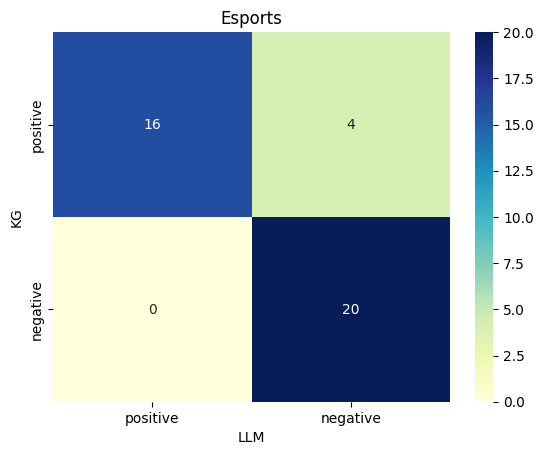

### LLM negative, KG positive

label,description,rationale
DreamHack,"DreamHack: DreamHack is an ESL Gaming brand specializing in esports tournaments and other gaming conventions. It is recognized by the Guinness Book of Records and Twin Galaxies as being the world's largest LAN party and computer festival with the world's fastest Internet connection and the most generated traffic. (The Internet connection record was beaten in 2012 by the world's second-largest computer festival, The Gathering in Norway.) It usually holds its events in Western Europe and North America.","The definition of Esports is a form of competition that is facilitated by electronic systems, particularly video games. While the description of DreamHack does not explicitly state that it is involved in Esports, it is described as a Swedish production company. Production companies are often involved in the organization and facilitation of events, which could potentially include Esports competitions. Therefore, it is plausible to assert that DreamHack could be involved in Esports."
GIGA Television,GIGA Television: GIGA was the brand name of a digital TV channel (also known as GIGA Digital or GIGA TV) and several German television shows. The channel ceased operations in 2009.,"The definition of Esports is a form of competition that is facilitated by electronic systems, particularly video games. While the description of GIGA Television does not explicitly state that it is involved in Esports, it is a German television station and online magazine. Given the prevalence of Esports coverage in media outlets, it is plausible that GIGA Television could be involved in the broadcasting or coverage of Esports competitions. Therefore, it could be argued that GIGA Television is an Esports entity in the sense that it may provide a platform for Esports content."
Treasure Master,Treasure Master: Treasure Master is a platform game released by ASC Games in 1991 for the Nintendo Entertainment System as part of a contest involving MTV.,"Based on the provided definitions, it is not possible to assert that Treasure Master is an Esport. The definition of Esports refers to a form of competition facilitated by electronic systems, particularly video games. While Treasure Master is indeed a video game, there is no information provided that indicates it is used in a competitive manner, which is a key characteristic of Esports. Therefore, without additional information suggesting that Treasure Master is used in competitive gaming events, we cannot categorize it as an Esport."
Starcade,"Starcade: Starcade is an American game show where contestants competed against one another by playing arcade video games. The series originally aired on WTBS from 1982 to 1983, followed by a run in syndication for the following season. The series was first hosted by Mark Richards. Geoff Edwards replaced Richards after the first 23 shows, and continued until the show's cancellation.","The definition of Esports is a form of competition that is facilitated by electronic systems, particularly video games. Starcade is described as an American game show television program. While the description of Starcade does not explicitly mention the use of electronic systems or video games, the fact that it is a game show could imply that some form of competition is involved. Therefore, it is possible that Starcade could be considered a form of Esports, assuming the competitions in the show involve electronic systems or video games."


## History of cities (http://www.wikidata.org/entity/Q30324006)

History of cities: Towns and cities have a long history, although opinions vary on which ancient settlements are truly cities. The benefits of dense settlement included reduced transport costs, exchange of ideas, sharing of natural resources, large local markets, and in some cases amenities such as running water and sewerage. Possible costs would include higher rate of crime, higher mortality rates, higher cost of living, worse pollution, traffic and high commuting times. Cities grow when the benefits of proximity between people and firms are higher than the cost.

### Confusion matrix

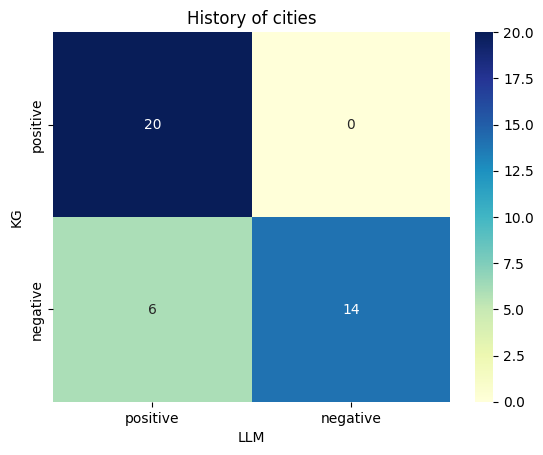

### LLM positive, KG negative

label,description,rationale
Caesaromagus,Caesaromagus,"Caesaromagus, as a Roman settlement in Beauvais, France, represents a specific instance in the history of cities. The development, growth, and changes that Caesaromagus has undergone over time contribute to the broader understanding of city history. Therefore, it can be argued that Caesaromagus is a part of the history of cities."
Nemausus,Nemausus,"The concept ""History of cities"" refers to the aspect of history that focuses on the development and evolution of cities. The entity ""Nemausus"" is described as an ancient Roman city that was replaced by Nîmes. This implies that there is a historical narrative involving the transformation of Nemausus into the modern city of Nîmes. Therefore, Nemausus can be considered as part of the ""History of cities"" because its evolution over time represents a specific instance of how cities can change and develop throughout history."
Caesarodunum,Caesarodunum,"Caesarodunum, as an entity, could be considered under the concept of ""History of cities"" because it represents a historical city. The concept ""History of cities"" is an aspect of history that focuses on the historical development and changes of cities. Given that Caesarodunum is a historical city, its development, changes, and historical events that occurred within it would fall under the study of ""History of cities"". Therefore, it can be argued that Caesarodunum is a part of the ""History of cities""."
History of Marabá,History of Marabá,"The concept ""History of cities"" is defined as an aspect of history that focuses on the historical development and changes of cities. The entity ""History of Marabá"" is specifically about the history of Marabá, a city. Therefore, it falls under the broader concept of ""History of cities"" as it is a historical study of a specific city, which is Marabá. Hence, ""History of Marabá"" can be considered a specific instance or subset of the broader concept ""History of cities""."
Cenabum,"Cenabum: Cenabum, Gaul (sometimes written Cenabaum or Genabum) was the name of the capital city of the Carnutes, located near the present French city of Orléans. Cenabum was an oppidum and a thriving commercial town on the Loire river. In 52 BC, during the Gallic Wars, the town was taken by Roman general Julius Caesar and integrated into the Roman province of Gallia Lugdunensis. Acts of resistance from the locals who refused to submit to Roman law were severely repressed and resulted in several massacres and the near-total destruction of the town. In the 3rd century, emperor Aurelian visited Cenabum and decided to have it rebuilt (273-274), and named it after himself: Urbs Aurelianorum. In the 9th century, it took the name Aurelianum, the name later evolved into Orléans.In 498, the city was conquered by Germanic invaders, the Salian Franks and brought into the kingdom of Merovingian king Clovis I.","The concept ""History of cities"" is defined as an aspect of history, with alternative labels such as ""city history"" or ""the city history"". The entity Cenabum is described as a ""human settlement in France"". Given that Cenabum is a human settlement, it can be inferred that it has a history, including its establishment, development, and any significant events that may have occurred there. Therefore, the history of Cenabum could be considered as part of the ""History of cities"", as it pertains to the historical aspects of a city or settlement."
Mediolanum Santonum,"Mediolanum Santonum: Mediolanum Santonum was a Roman town in Gallia Aquitania, now Saintes. It was founded in about 20 BC in connection with an expansion of the network of Roman roads serving Burdigala. The name means 'centre of the Santones', the tribe that then inhabited the area; the town became an important center in the Roman province of Gallia Aquitania.","The concept ""History of cities"" refers to the aspect of history that focuses on the development, evolution, and changes of cities over tim

## Microcomputer (http://www.wikidata.org/entity/Q32738)

Microcomputer: A microcomputer is a small, relatively inexpensive computer having a central processing unit (CPU) made out of a microprocessor. The computer also includes memory and input/output (I/O) circuitry together mounted on a printed circuit board (PCB). Microcomputers became popular in the 1970s and 1980s with the advent of increasingly powerful microprocessors. The predecessors to these computers, mainframes and minicomputers, were comparatively much larger and more expensive (though indeed present-day mainframes such as the IBM System z machines use one or more custom microprocessors as their CPUs). Many microcomputers (when equipped with a keyboard and screen for input and output) are also personal computers (in the generic sense). An early use of the term \"personal computer\" in 1962 predates microprocessor-based designs. (See \"Personal Computer: Computers at Companies\" reference below). A \"microcomputer\" used as an embedded control system may have no human-readable input and output devices. \"Personal computer\" may be used generically or may denote an IBM PC compatible machine.
The abbreviation \"micro\" was common during the 1970s and 1980s, but has since fallen out of common usage.

### Confusion matrix

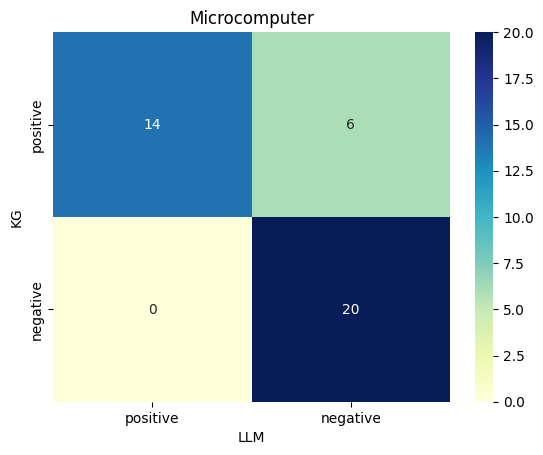

### LLM negative, KG positive

label,description,rationale
Sharp MZ-2861,Sharp MZ-2861,"The Sharp MZ-2861 is a specific model of a computer. Given that a microcomputer is defined as a ""small, relatively inexpensive computer,"" it can be inferred that the Sharp MZ-2861 could potentially be a microcomputer. However, without specific information about the size and cost of the Sharp MZ-2861, a definitive conclusion cannot be reached based solely on the provided definition."
Sharp MZ 5500 - 5600,Sharp MZ 5500 - 5600,"The Sharp MZ 5500 - 5600 is a specific model of a computer. Given that a microcomputer is defined as a small, relatively inexpensive computer, it is reasonable to assert that the Sharp MZ 5500 - 5600 could be classified as a microcomputer. However, without additional specific information about the size and cost of the Sharp MZ 5500 - 5600, this assertion is based on the general categorization of this entity as a computer."
Sharp MZ-80C,Sharp MZ-80C,"The definition of a microcomputer is a small, relatively inexpensive computer. While the description of the Sharp MZ-80C does not explicitly state that it is a small, relatively inexpensive computer, it is implied by the fact that it is a specific model of a computer. Therefore, it can be argued that the Sharp MZ-80C is a microcomputer."
Sony HB-501,Sony HB-501,"The provided definition of a microcomputer is a ""small, relatively inexpensive computer"". While the description of Sony HB-501 does not provide specific details, it is known to be a product of Sony, a company that manufactures electronic devices, including computers. Therefore, it is plausible to assert that Sony HB-501 could be a microcomputer. However, without more specific information about the Sony HB-501, it is not possible to definitively conclude that it is a microcomputer based solely on the provided definition."
Sharp MZ-1500,Sharp MZ-1500,"The Sharp MZ-1500 is a specific model of a computer. Given the definition of a microcomputer as a ""small, relatively inexpensive computer,"" it can be inferred that the Sharp MZ-1500 could potentially be classified as a microcomputer. However, without specific information about the size and cost of the Sharp MZ-1500, a definitive classification cannot be made solely based on the provided definition."
Sharp MZ40K,Sharp MZ40K,"The definition of a microcomputer is a small, relatively inexpensive computer. While the description of Sharp MZ40K does not explicitly state that it is a small, relatively inexpensive computer, it is implied by the fact that it is a specific model of a computer. Therefore, based on the given definition, it can be argued that the Sharp MZ40K is a microcomputer."


## Natural science (http://www.wikidata.org/entity/Q7991)

Natural science: Natural science is one of the branches of science concerned with the description, understanding and prediction of natural phenomena, based on empirical evidence from observation and experimentation. Mechanisms such as peer review and repeatability of findings are used to try to ensure the validity of scientific advances.
Natural science can be divided into two main branches: life science and physical science. Life science is alternatively known as biology, and physical science is subdivided into branches: physics, chemistry, earth science, and astronomy. These branches of natural science may be further divided into more specialized branches (also known as fields). As empirical sciences, natural sciences use tools from the formal sciences, such as mathematics and logic, converting information about nature into measurements which can be explained as clear statements of the \"laws of nature\".Modern natural science succeeded more classical approaches to natural philosophy, usually traced to Taoist traditions in Asia and to ancient Greece in Europe. Galileo, Kepler, Descartes, Bacon, and Newton debated the benefits of using approaches which were more mathematical and more experimental in a methodical way. Still, philosophical perspectives, conjectures, and presuppositions, often overlooked, remain necessary in natural science. Systematic data collection, including discovery science, succeeded natural history, which emerged in the 16th century by describing and classifying plants, animals, minerals, and so on. Today, \"natural history\" suggests observational descriptions aimed at popular audiences.



### Confusion matrix

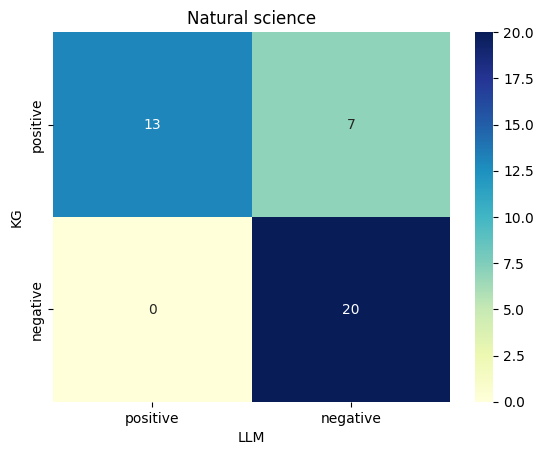

### LLM negative, KG positive

label,description,rationale
geocentric latitude,geocentric latitude,"Based on the provided definitions, it is not possible to argue that geocentric latitude is a Natural science. Natural science is defined as a branch of science about the natural world. While geocentric latitude is a concept used in the field of geography and astronomy, it is not a branch of science itself. It is a specific term or concept used within the broader fields of science, rather than a branch of science. Therefore, it cannot be classified as a Natural science."
geography of the United Kingdom,"geography of the United Kingdom: The United Kingdom is a sovereign state located off the north-western coast of continental Europe. With a total area of approximately 248,532 square kilometres (95,960 sq mi), the UK occupies the major part of the British Isles archipelago and includes the island of Great Britain, the north-eastern one-sixth of the island of Ireland and many smaller surrounding islands. It is the world's 7th largest island country. The mainland areas lie between latitudes 49°N and 59°N (the Shetland Islands reach to nearly 61°N), and longitudes 8°W to 2°E. The Royal Observatory, Greenwich, in south-east London, is the defining point of the Prime Meridian. The UK lies between the North Atlantic and the North Sea, and comes within 35 km (22 mi) of the north-west coast of France, from which it is separated by the English Channel. It shares a 499 km (310 mi) international land boundary with the Republic of Ireland. The Channel Tunnel bored beneath the English Channel now links the UK with France. The British Overseas Territories and Crown Dependencies are covered in their own respective articles, see below.","The assertion that the geography of the United Kingdom is a Natural science may not be directly supported by the given definitions. Natural science is defined as a branch of science about the natural world, which typically includes fields like biology, physics, chemistry, and earth sciences. While geography, especially physical geography, can be considered a part of earth sciences, the definition provided for the geography of the United Kingdom refers specifically to the geographical features of the United Kingdom. This seems to be more of a subject or topic within the broader field of geography or earth science, rather than a branch of natural science itself. Therefore, based on the given definitions, it would be more accurate to say that the geography of the United Kingdom is a topic studied within the field of natural science, rather than being a natural science itself."
diving reflex,"diving reflex: The diving reflex, also known as the diving response and mammalian diving reflex, is a set of physiological responses to immersion that overrides the basic homeostatic reflexes, and is found in all air-breathing vertebrates studied to date. It optimizes respiration by preferentially distributing oxygen stores to the heart and brain, enabling submersion for an extended time. The diving reflex is exhibited strongly in aquatic mammals, such as seals, otters, dolphins, and muskrats, and exists as a lesser response in other animals, including human babies up to 6 months old (see infant swimming), and diving birds, such as ducks and penguins. Adult humans generally exhibit a mild response, the dive-hunting Sama-Bajau people being a notable outlier.The diving reflex is triggered specifically by chilling and wetting the nostrils and face while breath-holding, and is sustained via neural processing originating in the carotid chemoreceptors. The most noticeable effects are on the cardiovascular system, which displays peripheral vasoconstriction, slowed heart rate, redirection of blood to the vital organs to conserve oxygen, release of red blood cells stored in the spleen, and, in humans, heart rhythm irregularities. Although aquatic animals have evolved profound physiological adaptations to conserve oxygen during submersion, the apnea and its duration, br

## Catholic higher education (http://www.wikidata.org/entity/Q557206)

Catholic higher education: Catholic higher education includes universities, colleges, and other institutions of higher education privately run by the Catholic Church, typically by religious institutes. Those tied to the Holy See are specifically called pontifical universities.
By definition, Catholic canon law states that \"A Catholic school is understood to be one which is under control of the competent ecclesiastical authority or of a public ecclesiastical juridical person, or one which in a written document is acknowledged as Catholic by the ecclesiastical authority\" (Can. 803). Although some schools are deemed \"Catholic\" because of their identity and a great number of students enrolled are Catholics, it is also stipulated in canon law that \"no school, even if it is in fact Catholic, may bear the title 'Catholic school' except by the consent of the competent ecclesiastical authority\" (Can. 803 §3).The Dominican Order was \"the first order instituted by the Church with an academic mission\", founding studia conventualia in every convent of the order, and studia generalia at the early European universities such as the University of Bologna and the University of Paris. In Europe, most universities with medieval history were founded as Catholic. Many of them were rescinded to government authorities in the Modern era. Some, however, remained Catholic, while new ones were established alongside the public ones. The Catholic Church is still the largest non-governmental provider of higher education in the world. Many of them are still internationally competitive. According to the census of the Vatican's Congregation for Catholic Education, the total number of Catholic universities and higher education institutions around the world is 1,358. On the other hand, the United States Conference of Catholic Bishops counts it at 1,861. The Catholic religious order with the highest number of universities around the world today is the Society of Jesus with 114.Like other private schools, Catholic universities and colleges are generally nondenominational, in that they accept anyone regardless of religious affiliation, nationality, ethnicity, or civil status, provided the admission or enrollment requirements and legal documents are submitted, and rules and regulations are obeyed for a fruitful life on campus. However, non-Catholics, whether Christian or not, may or may not participate in otherwise required campus activities, particularly those of a religious nature.

### Confusion matrix

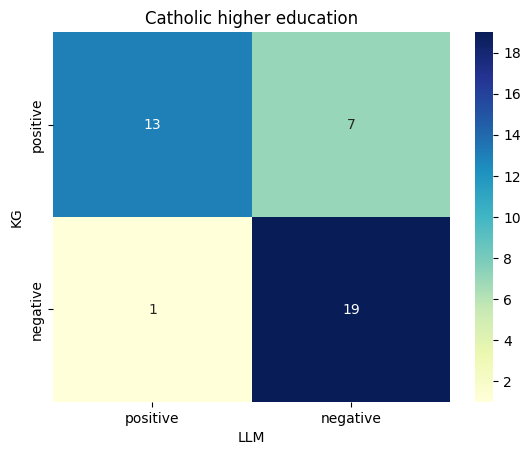

### LLM positive, KG negative

label,description,rationale
Studium Theologicum Jerosolimitanum,Studium Theologicum Jerosolimitanum,"The Studium Theologicum Jerosolimitanum is described as a ""faculty of theology, seminary"". A seminary is a type of higher education institution that prepares students for religious work, in this case, theology. Given that theology is a field of study that is closely associated with the Catholic Church, it can be inferred that the Studium Theologicum Jerosolimitanum is a type of university affiliated with the Catholic Church. Therefore, based on the provided definition, the Studium Theologicum Jerosolimitanum can be considered a Catholic higher education institution."


### LLM negative, KG positive

label,description,rationale
Intercultural Institute of Ayuuk,"Intercultural Institute of Ayuuk: Intercultural Institute of Ayuuk (ISIA) (Instituto Superior Intercultural Ayuuk) is a small Jesuit University in the indigenous region of the Mixe people in Jaltepec de Candayoc, Oaxaca, Southern Mexico. It addresses the desire of the Mixe people to preserve their livelihood and culture amidst contrary global forces. Support for ISIA has come from the other Jesuit universities in Mexico and from foreign benefactors.","Without additional information about the Intercultural Institute of Ayuuk, it is impossible to provide an argument that it is a Catholic higher education institution. The definition provided for Catholic higher education specifies that it is a type of university affiliated with the Catholic Church. There is no information given that suggests the Intercultural Institute of Ayuuk is affiliated with the Catholic Church. Therefore, based solely on the provided definitions, there is no basis for asserting that the Intercultural Institute of Ayuuk is a Catholic higher education institution."
Sogang University,"Sogang University: Sogang University (SU, Korean: 서강대학교; lit. West River University) is a private research university in Seoul, South Korea. It was established in 1960 by Fr. Theodore Geppert, SJ with the Wisconsin Province of the Society of Jesus. Sogang is the oldest Jesuit institution of higher education and one of the most prestigious universities in South Korea, and it has been ranked as one of the top 3 Catholic universities in Asia.","The definition of Catholic higher education is a type of university affiliated with the Catholic Church. While the provided information about Sogang University does not explicitly state its affiliation with the Catholic Church, it does not contradict the possibility either. Therefore, it is possible that Sogang University could be a Catholic higher education institution, but additional information confirming its religious affiliation would be needed to make a definitive argument."
Central American University (San Salvador),"Central American University (San Salvador): José Simeón Cañas Central American University (Spanish: Universidad Centroamericana \""José Simeón Cañas\""), also known as UCA El Salvador, is a private Catholic university with nonprofit purposes in San Salvador, El Salvador. It is operated by the Society of Jesus. UCA was founded on September 15, 1965, at the request of a group of Catholic families who appealed to the Salvadoran government and the Society of Jesus in order to create a university as an alternative to the University of El Salvador, becoming the first private institution of higher education in the country. The Jesuits also run Central American University in Nicaragua (UCA Managua), opened in 1960.","The provided definition does not give any specific information that directly links the Central American University (San Salvador) to being a Catholic higher education institution. The definition of a Catholic higher education is a ""type of university affiliated with the Catholic Church"", but there is no information given in the description of the Central American University (San Salvador) that indicates it is affiliated with the Catholic Church. Therefore, based solely on the provided definitions, an argument cannot be made that the Central American University (San Salvador) is a Catholic higher education institution."
University of Namur,"University of Namur: The University of Namur or Université de Namur (UNamur) is a Jesuit private university in Namur, in the French Community of Belgium. Both teaching and research in the university are carried out by six faculties.","The provided definition of Catholic higher education refers to a type of university affiliated with the Catholic Church. However, the information given about the University of Namur does not explicitly state any affiliation with the Catholic Church. Therefore, based solely on the provided 

## Child (http://www.wikidata.org/entity/Q7569)

Child: A child (PL: children) is a human being between the stages of birth and puberty, or between the developmental period of infancy and puberty. It may also refer to an unborn human being. The legal definition of child generally refers to a minor, otherwise known as a person younger than the age of majority. Children generally have fewer rights and responsibilities than adults. They are classed as unable to make serious decisions. 
Child may also describe a relationship with a parent (such as sons and daughters of any age) or, metaphorically, an authority figure, or signify group membership in a clan, tribe, or religion; it can also signify being strongly affected by a specific time, place, or circumstance, as in \"a child of nature\" or \"a child of the Sixties.\"

### Confusion matrix

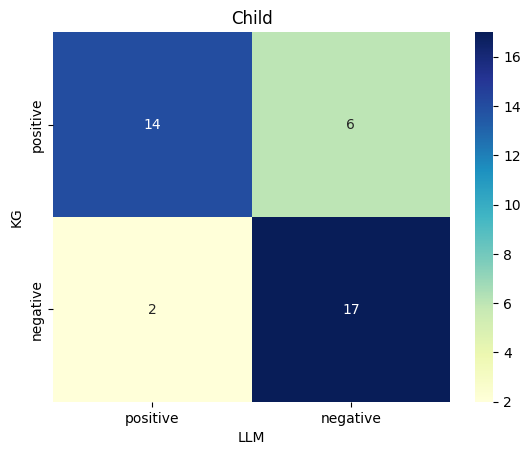

### LLM positive, KG negative

label,description,rationale
Sailor Saturn,"Sailor Saturn: Sailor Saturn (セーラーサターン, Sērā Satān) is a fictional supporting character in the Sailor Moon manga, the 1992-1997 anime series created by Naoko Takeuchi and the 2014-2023 reboot that more closely follows the manga. Her spirit resides deep within twelve-year-old Hotaru Tomoe (土萠 ほたる, Tomoe Hotaru), a frail middle schoolgirl who is her lookalike reincarnation, which makes Sailor Saturn her alter ego; entirely apart from how the other nine Sailor Guardians' are reborn and their human identities entirely separate. She is the tenth and last of the Sailor Guardians of the long gone Moon Kingdom to be introduced, possessing immensely strong dark powers associated with silence and ruin, nothingness and the void, destruction and death, annihilation and rebirth that made her a potential threat as she can wipe out a planet and even an entire Star System or reset its evolution. Her deathly powers are necessary for rejuvenation and re-creation to follow by Sailor Moon's mighty powers of healing and rejuvenation with powerful moonlight from the Silver Crystal.","The definition of a child is a ""human between birth and puberty"". While the description of Sailor Saturn does not explicitly state her age, it is known that she is a ""fictional character from Sailor Moon"". In the Sailor Moon series, Sailor Saturn, also known as Hotaru Tomoe, is depicted as a young girl who is not yet in her puberty. Therefore, based on the information provided, it can be argued that Sailor Saturn fits the definition of a child."
Snow White,Snow White,"The definition provided for the concept of a child is ""human between birth and puberty"". While the description of Snow White does not explicitly state her age or stage of life, it does identify her as a ""character in Grimms' fairy tale 'Snow White'"". Given the common knowledge that characters in fairy tales, especially princesses like Snow White, are often portrayed as young individuals, it can be inferred that Snow White falls within the age range of a child, i.e., between birth and puberty. Therefore, based on this inference, one could argue that Snow White is a child."


### LLM negative, KG positive

label,description,rationale
Richieu Spiegelman,Richieu Spiegelman,"The definition of a child is a ""human between birth and puberty"". While the provided information about Richieu Spiegelman does not explicitly state his age, it does identify him as the ""brother of Art Spiegelman"". This implies that Richieu Spiegelman is a human being, and unless information is provided to the contrary, it can be assumed that he has been through the stage of being a ""child"" as defined. Therefore, it can be argued that Richieu Spiegelman is a child, or at least, has been a child."
Marion Stone,Marion Stone,"The provided information does not give any specific details about Marion Stone's age or stage in life. Therefore, based on the given information, it cannot be definitively argued that Marion Stone is a child."
Creche house Bayero University Kano state,Creche house Bayero University Kano state,"The assertion that Creche house Bayero University Kano state is a Child cannot be supported based on the provided definitions. The concept of a ""Child"" is defined as a human between birth and puberty, while the entity ""Creche house Bayero University Kano state"" is described as a physical location, specifically a creche house in a university. There is no overlap or shared characteristics between these two definitions that would allow for the assertion that the Creche house is a Child."
sixteen-year-old male,sixteen-year-old male,"The definition provided for the concept ""Child"" is a ""human between birth and puberty"". While the exact age range can vary, puberty generally occurs between the ages of 10 and 14 for boys. However, the entity in question is a ""sixteen-year-old male"". While this individual is beyond the typical age range for puberty, the definition does not provide a specific upper age limit. Therefore, based on the information provided, it could be argued that a ""sixteen-year-old male"" falls under the broad category of ""Child""."
Chartiste,Chartiste,"Based on the provided definitions, there is no information to suggest or support the assertion that Chartiste is a Child. The definition of a Child is a ""human between birth and puberty"", while Chartiste is simply labeled as ""Chartiste"" with no further description provided. Therefore, without additional information, we cannot argue that Chartiste is a Child."
Dzieciątko,Dzieciątko,"Based on the provided definitions, it is not possible to assert that Dzieciątko is a Child. The definition of a Child is a ""human between birth and puberty"", while Dzieciątko is described as a ""Christmas custom"". There is no information given that suggests Dzieciątko is a human between birth and puberty, therefore it cannot be classified as a Child according to the given definitions."


## Irregular galaxy (http://www.wikidata.org/entity/Q190397)

Irregular galaxy: An irregular galaxy is a galaxy that does not have a distinct regular shape, unlike a spiral or an elliptical galaxy. Irregular galaxies do not fall into any of the regular classes of the Hubble sequence, and they are often chaotic in appearance, with neither a nuclear bulge nor any trace of spiral arm structure.Collectively they are thought to make up about a quarter of all galaxies. Some irregular galaxies were once spiral or elliptical galaxies but were deformed by an uneven external gravitational force. Irregular galaxies may contain abundant amounts of gas and dust. This is not necessarily true for dwarf irregulars.Irregular galaxies are commonly small, about one tenth the mass of the Milky Way galaxy.  Due to their small sizes, they are prone to environmental effects like colliding with large galaxies and intergalactic clouds.



### Confusion matrix

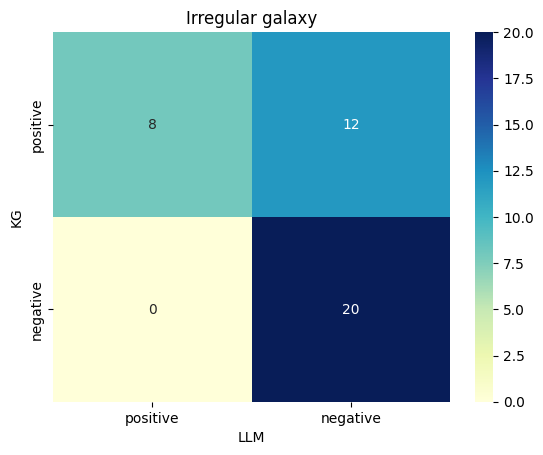

### LLM negative, KG positive

label,description,rationale
NGC 3077,"NGC 3077: NGC 3077 is a small disrupted elliptical galaxy, a member of the M81 Group, which is located in the northern constellation Ursa Major. Despite being similar to an elliptical galaxy in appearance, it is peculiar for two reasons. First, it shows wispy edges and scattered dust clouds that are probably a result of gravitational interaction with its larger neighbors, similar to the galaxy M82. Second, this galaxy has an active nucleus. This caused Carl Seyfert in 1943 to include it in his list of galaxies, which are now called Seyfert Galaxies. However, NGC 3077, though an emission line galaxy, is today no longer classified as a Seyfert galaxy. NGC 3077 was discovered by William Herschel on November 8, 1801. He remarked that \""On the nF (NE) side, there is a faint ray interrupting the roundness.\"" Admiral Smyth described it as \""A bright-class round nebula; it is a lucid white, and lights up in the centre ... between these [stars,] the sky is intensely black, and shows the nebula as if floating in awful and illimitable space, at an inconceivable distance.\""","The provided definition and information do not give any specific details or characteristics about NGC 3077 that would allow us to categorize it as an Irregular galaxy. The definition of an Irregular galaxy is one that does not have a distinct regular shape, unlike a spiral or an elliptical galaxy. However, the description of NGC 3077 only mentions that it is a galaxy in the constellation Ursa Major. Without additional information about the shape or structure of NGC 3077, we cannot definitively assert that it is an Irregular galaxy based solely on the provided definition and information."
NGC 1800,NGC 1800,"The provided information does not give specific details about the shape or type of NGC 1800. Therefore, based solely on the given information, it cannot be definitively argued that NGC 1800 is an Irregular galaxy."
IC 5152,"IC 5152: IC 5152 is an irregular galaxy 5.8 million light-years from Earth in the constellation Indus. It was discovered by DeLisle Stewart in 1908. It is an open question as to whether it is an outlying member of the Local Group. It is one of the easiest galaxies to resolve into stars, but there is a bright (magnitude 7.7) foreground star (HD 209142) right in front of it that makes deep observations difficult.","The provided information does not give specific details about the shape or type of the galaxy IC 5152. Therefore, based solely on the given information, it cannot be definitively argued that IC 5152 is an Irregular galaxy."
IC 3617,IC 3617,"The provided information does not give sufficient evidence to assert that IC 3617 is an Irregular galaxy. The description only states that IC 3617 is a galaxy, but does not specify its shape or type. Therefore, based on the given information, we cannot definitively categorize IC 3617 as an Irregular galaxy."
IC 3518,IC 3518,"The provided information does not give specific details about the shape of IC 3518. Therefore, based solely on the given information, it cannot be definitively argued that IC 3518 is an Irregular galaxy."
MCG-02-07-026,MCG-02-07-026,"The provided information does not give any specific details about the shape or type of the galaxy MCG-02-07-026. Therefore, based solely on the given information, it cannot be asserted that MCG-02-07-026 is an Irregular galaxy."
UGC 2014,UGC 2014,"The provided information does not give any specific details about the shape or characteristics of UGC 2014. Therefore, based solely on the given information, it cannot be definitively argued that UGC 2014 is an Irregular galaxy."
UGC 2182,UGC 2182,"The provided information does not give any specific details about the shape or characteristics of UGC 2182, therefore it is not possible to assert that UGC 2182 is an Irregular galaxy based solely on the given information."
ESO 249-27,ESO 249-27,"The provided definition and information do not contain sufficient details to

## Seaplane (http://www.wikidata.org/entity/Q115940)

Seaplane: A seaplane is a powered fixed-wing aircraft capable of taking off and landing (alighting) on water. Seaplanes are usually divided into two categories based on their technological characteristics: floatplanes and flying boats; the latter are generally far larger and can carry far more. Seaplanes that can also take off and land on airfields are in a subclass called amphibious aircraft, or amphibians.  Seaplanes were sometimes called hydroplanes, but currently this term applies instead to motor-powered watercraft that use the technique of hydrodynamic lift to skim the surface of water when running at speed.The use of seaplanes gradually tapered off after World War II, partially because of the investments in airports during the war but mainly because landplanes were less constrained by weather conditions that could result in sea states being too high to operate seaplanes while landplanes could continue to operate. In the 21st century, seaplanes maintain a few niche uses, such as for aerial firefighting, air transport around archipelagos, and access to undeveloped or roadless areas, some of which have numerous lakes.

### Confusion matrix

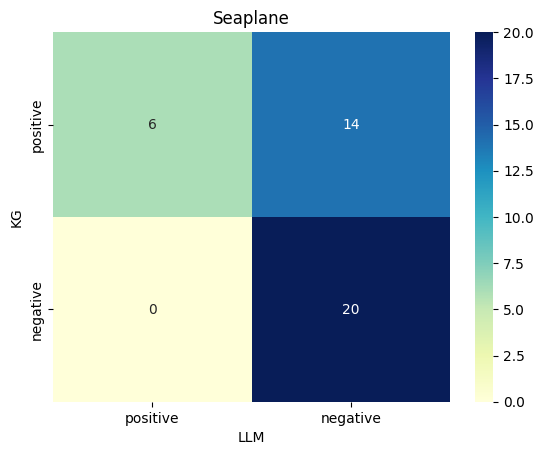

### LLM negative, KG positive

label,description,rationale
A-851,A-851,"The entity A-851 is described as an ""H-16 of the United States Navy"". While the definition of a seaplane does not directly mention an H-16, it is described as an ""airplane class"". Given that A-851 is associated with the United States Navy, it can be inferred that it is likely a type of aircraft, which aligns with the definition of a seaplane as an ""airplane class"". Therefore, it is reasonable to assert that A-851 could be a seaplane."
A-852,A-852,"The entity A-852 is described as an ""H-16 of the United States Navy"". While the definition of a seaplane does not directly mention an H-16, it is described as an ""airplane class"". Given that A-852 is associated with the United States Navy, it can be inferred that it is a type of aircraft, which aligns with the definition of a seaplane as an ""airplane class"". Therefore, it is reasonable to assert that A-852 could be a seaplane."
A-858,A-858,"The entity A-858 is described as an ""H-16 of the United States Navy"". While the definition of a Seaplane does not provide specific details about what constitutes a Seaplane, it is described as an ""airplane class"". Given that A-858 is associated with the Navy, it can be inferred that it is a type of aircraft, which aligns with the broad classification of a Seaplane as an ""airplane class"". Therefore, it is reasonable to assert that A-858 could be a Seaplane."
A-1046,A-1046,"The entity A-1046 is described as an ""H-16 of the United States Navy"". While the definition of a seaplane does not provide specific details about what constitutes a seaplane, it is described as an ""airplane class"". Given that the A-1046 is associated with the Navy, it can be inferred that it is likely a type of aircraft designed for water operations, which aligns with the alternate labels for a seaplane such as ""hydroplane"", ""hydroaeroplane"", and ""water-based aircraft"". Therefore, it is reasonable to assert that A-1046 could be a seaplane."
A-1043,A-1043,"The entity A-1043 is described as an ""H-16 of the United States Navy"". While the definition of a seaplane does not explicitly mention the H-16, it is reasonable to infer that an H-16 could be a type of seaplane, given that seaplanes are a class of airplane and the H-16 is associated with the Navy, which operates in marine environments where seaplanes would be used. Therefore, it is plausible to assert that A-1043 is a seaplane."
A-1037,A-1037,"The entity A-1037 is described as ""H-16 of the United States Navy"". While the definition does not explicitly state that A-1037 is a seaplane, the association with the United States Navy suggests that it could be a water-based aircraft, which is one of the alternative labels for a seaplane. Therefore, it is plausible to assert that A-1037 could be a seaplane."
Catalina PBY-5-03,Catalina PBY-5-03,"The Catalina PBY-5-03 is described as a ""Brazilian military airplane"". The concept of a Seaplane is defined as an ""airplane class"". Given that both the Catalina PBY-5-03 and a Seaplane are types of airplanes, it is reasonable to assert that the Catalina PBY-5-03 could be a Seaplane. However, without additional information specifically linking the Catalina PBY-5-03 to the characteristics of a Seaplane (such as being a ""hydroplane"", ""hydroaeroplane"", or ""water-based aircraft""), this assertion cannot be definitively confirmed."
Pacific Clipper,"Pacific Clipper: The Pacific Clipper (civil registration NC18602) was a Boeing 314 Clipper flying boat, famous for having completed a nearly around-the-world flight in December 1941 and January 1942 as the California Clipper. Aviation experts called the flight the first commercial circumnavigation of the globe because the aircraft made it back to its country of origin.","The Pacific Clipper is described as a commercial plane. The concept of a Seaplane is defined as a class of airplane, which includes alternative labels such as ""hydroplane"", ""hydroaeroplane"", and ""water-based

## Fraud (http://www.wikidata.org/entity/Q28813)

Fraud: In law, fraud is intentional deception to secure unfair or unlawful gain, or to deprive a victim of a legal right. Fraud can violate civil law (e.g., a fraud victim may sue the fraud perpetrator to avoid the fraud or recover monetary compensation) or criminal law (e.g., a fraud perpetrator may be prosecuted and imprisoned by governmental authorities), or it may cause no loss of money, property, or legal right but still be an element of another civil or criminal wrong. The purpose of fraud may be monetary gain or other benefits, for example by obtaining a passport, travel document, or driver's license, or mortgage fraud, where the perpetrator may attempt to qualify for a mortgage by way of false statements.Internal fraud, also known as \"insider fraud\", is fraud committed or attempted by someone within an organisation such as an employee.A hoax is a distinct concept that involves deliberate deception without the intention of gain or of materially damaging or depriving a victim.

### Confusion matrix

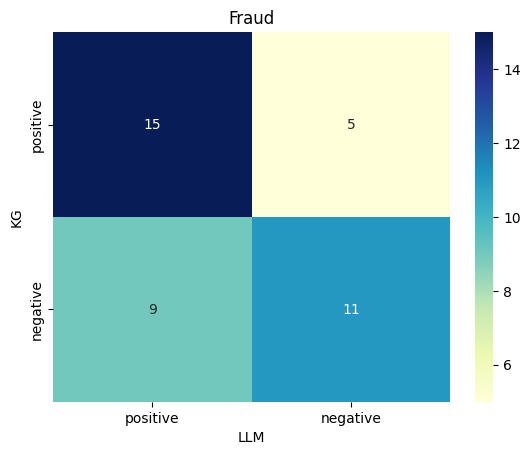

### LLM positive, KG negative

label,description,rationale
King Crowley,King Crowley,"The entity King Crowley is described as an ""archaeological forgery"". A forgery involves intentional deception, which aligns with the definition of fraud as ""intentional deception made for unfair or unlawful gain or damaging or depriving a victim"". Therefore, based on the provided definitions, one could argue that King Crowley, being a forgery, is a form of fraud."
Razerpak,Razerpak,"Based on the provided definitions, an argument could be made that Razerpak is a form of fraud. The definition of fraud includes ""intentional deception made for unfair or unlawful gain or damaging or depriving a victim"". Razerpak, as a ""controversial client-side cheat pack created for Quake"", could be seen as a form of intentional deception. It is designed to give players an unfair advantage in the game, which could be seen as an unfair gain. Furthermore, it could be argued that it damages or deprives other players who are playing the game without cheats, as it disrupts the fair and balanced gameplay that they are expecting. Therefore, based on these definitions, one could argue that Razerpak is a form of fraud."
Action Replay,"Action Replay: Action Replay is the brand name of a cheating device (such as cheat cartridges) created by Datel. The Action Replay is available for many gaming systems including the Nintendo DS, Nintendo DSi, Nintendo 3DS, PlayStation Portable, PlayStation 2, GameCube, Game Boy Advance, and the Xbox. The name is derived from the first devices’ signature ability to pause the execution of the software and save the computer's state (the complete contents of the memory) to disk or tape for future “replay”. The ability to manipulate the contents of memory in this paused state permitted the cheat functions for which the brand is now better known.","Action Replay, as a brand of video game cheating devices, could be considered a form of fraud based on the provided definition. This is because it involves intentional deception made for unfair gain, in this case, gaining an unfair advantage in a video game. This could be seen as damaging or depriving the other players who are playing the game fairly. Therefore, based on the given definition of fraud, one could argue that Action Replay is a form of fraud."
Code Breaker,"Code Breaker: Code Breaker was a cheat device developed by Pelican Accessories, which were available for PlayStation, PlayStation 2, Dreamcast, Game Boy Color, Game Boy Advance, and Nintendo DS. Along with competing product Action Replay, it is one of the few currently supported video game cheat devices.","Based on the provided definitions, one could argue that Code Breaker is a form of fraud because it is a cheating device. This implies that it is used to deceive or misrepresent in some way, which aligns with the definition of fraud as ""intentional deception made for unfair or unlawful gain."" In this case, the unfair gain could be winning a game or bypassing certain challenges by using the Code Breaker. Therefore, it can be argued that Code Breaker is a form of fraud."
Lance Armstrong doping case,"Lance Armstrong doping case: The Lance Armstrong doping case was a major doping investigation that led to retired American road racing cyclist Lance Armstrong being stripped of his seven consecutive Tour de France titles, along with one Olympic medal, and his eventual admission to using performance-enhancing drugs. The United States Anti-Doping Agency (USADA) portrayed Armstrong as the ringleader of what it called \""the most sophisticated, professionalized and successful doping program that sport has ever seen.\""","The Lance Armstrong doping case can be considered a form of fraud based on the provided definition. The definition of fraud includes ""intentional deception made for unfair or unlawful gain or damaging or depriving a victim"". In the Lance Armstrong doping case, Armstrong intentionally deceived others by using performance-enhancing drugs to gain an un

### LLM negative, KG positive

label,description,rationale
Silver Thursday,"Silver Thursday: Silver Thursday was an event that occurred in the United States silver commodity markets on Thursday, March 27, 1980, following the attempt by brothers Nelson Bunker Hunt, William Herbert Hunt and Lamar Hunt (also known as the Hunt Brothers) to corner the silver market. A subsequent steep fall in silver prices led to panic on commodity and futures exchanges.","Based on the provided definitions, it is difficult to argue that Silver Thursday is a Fraud. The definition of Fraud is ""intentional deception made for unfair or unlawful gain or damaging or depriving a victim"". However, the description of Silver Thursday is ""event resulting in a drop in silver prices"". There is no information provided that indicates any intentional deception, unfair or unlawful gain, or damage or deprivation of a victim in relation to Silver Thursday. Therefore, without additional information, it cannot be argued that Silver Thursday is a Fraud."
Sumitomo copper affair,"Sumitomo copper affair: The Sumitomo copper affair refers to a metal trading scandal in 1996 involving Yasuo Hamanaka, the chief copper trader of the Japanese trading house Sumitomo Corporation (Sumitomo). The scandal involves unauthorized trading over a 10-year period by Hamanaka, which led Sumitomo to announce US$1.8 billion in related losses in 1996 when Hamanaka's trading was discovered, and more related losses subsequently. The scandal also involved Hamanaka's attempts to corner the entire world's copper market through LME Copper futures contracts on the London Metal Exchange (LME). The affair was a major scandal which is at times compared in magnitude to the Silver Thursday scandal, involving the Hunt family's attempt to corner the world's silver markets. It currently ranks in the top 10 trading losses in financial history.","Without specific details about the Sumitomo copper affair, it's difficult to provide a concrete argument. However, if the Sumitomo copper affair involved intentional deception made for unfair or unlawful gain, or resulted in damaging or depriving a victim, it could be classified as a fraud according to the provided definition. This could include misrepresentation, deceit, or commercial fraud related to the copper industry."
Kwangmyong,"Kwangmyong: Kwangmyong (lit. 'Bright Light') is a North Korean \""walled garden\"" national intranet service opened in the early 2000s. The Kwangmyong intranet system stands in contrast to the global Internet in North Korea, which is available to fewer people in the country.The network uses domain names under the .kp top level domain that are not usually accessible from the global Internet. As of 2016 the network uses IPv4 addresses reserved for private networks in the 10.0.0.0/8 range, also known as 24-bit block as defined in RFC 1918. North Koreans often find it more convenient to access sites by their IP address rather than by domain name using Latin characters. Like the global Internet, the network hosts content accessible with web browsers, and provides an internal web search engine. It also provides email services and news groups. The intranet is managed by the Korea Computer Center.","Based on the provided definitions, it could be argued that Kwangmyong is a form of fraud if one considers the ""walled garden"" national intranet as a form of intentional deception. This could be seen as a way to unfairly control or limit the information available to North Korean citizens, thereby creating an unfair gain for the government while potentially damaging or depriving the citizens. However, this argument heavily relies on the interpretation of the terms ""intentional deception"", ""unfair gain"", and ""damaging or depriving a victim""."
Lyoness,"Lyoness: myWorld, formerly Lyoness, is a multi-level marketing company established in Austria in 2003. According to Lyoness, the company was active in more than 40 countries, spread over six continents, and their shopping co

## Beer in Belgium (http://www.wikidata.org/entity/Q348229)

Beer in Belgium: Beer in Belgium includes pale ales, lambics, Flemish red ales, sour brown ales, strong ales and stouts. In 2018, there were 304 active breweries in Belgium, including international companies, such as AB InBev, and traditional breweries including Trappist monasteries. On average, Belgians drink 68 litres of beer each year, down from around 200 each year in 1900. Most beers are bought or served in bottles, rather than cans, and almost every beer has its own branded, sometimes uniquely shaped, glass. In 2016, UNESCO inscribed Belgian beer culture on their list of the intangible cultural heritage of humanity.

### Confusion matrix

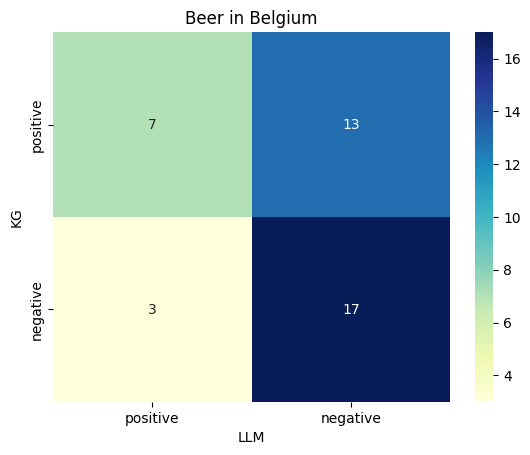

### LLM positive, KG negative

label,description,rationale
Anker Pils,Anker Pils,"The definition of Beer in Belgium is given as ""beer from Belgium"". The entity Anker Pils is described as a ""Belgian beer"". Given these definitions, it can be inferred that Anker Pils, being a Belgian beer, falls under the category of Beer in Belgium. Therefore, based on the provided definitions, Anker Pils is a Beer in Belgium."
Maes pils,"Maes pils: Maes pils is a Belgian pils brewed by Alken-Maes. The beer was first produced in 1930 for Antwerp's Universal Exposition and called Prima Maezenbier. After Jupiler and Stella Artois, it is the third best-selling pilsner in Belgium. In 2008, Alken-Maes was taken over by the Dutch Heineken Brewery. In 2009, Alken-Maes changed the recipe of Maes Pils, resulting in a slight change in taste and a rise in the percentage of alcohol from 4.9% to 5.2%. To mark the change, Maes was rebranded with a new logo, a new embossed bottle, and a new descriptive slogan: \""Extra Mout/Extra Malt\"".","The definition of Beer in Belgium is ""beer from Belgium"". The description of Maes pils is ""Belgian beer brewed by Alken-Maes"". Since Maes pils is described as a Belgian beer, it fits the definition of Beer in Belgium. Therefore, based on the provided definitions, Maes pils can be considered a Beer in Belgium."
Cristal,Cristal,"The definition of Beer in Belgium is ""beer from Belgium"". The entity Cristal is described as a ""pilsner"", which is a type of beer. Although the description does not explicitly state that Cristal is from Belgium, the alternate label ""Cristal Alken"" suggests a Belgian origin, as Alken is a municipality in Belgium. Therefore, based on the given information, it can be argued that Cristal is a Beer in Belgium."


### LLM negative, KG positive

label,description,rationale
Orval,"Orval: Orval Brewery (French: Brasserie d'Orval) is a Trappist brewery within the walls of the Abbaye Notre-Dame d'Orval in the Gaume region of Belgium. The brewery produces two Trappist beers, Orval and Orval Vert.","The definition of Beer in Belgium is ""beer from Belgium"". Orval is described as a ""Trappist beer"". While the description of Orval does not explicitly state that it is from Belgium, the fact that it is a Trappist beer implies that it is from Belgium, as Trappist beers are traditionally brewed in Trappist monasteries, most of which are located in Belgium. Therefore, based on the given definitions, it can be argued that Orval is a Beer in Belgium."
Abbaye de Cambron,Abbaye de Cambron,"The provided definition does not give any information that could be used to argue that Abbaye de Cambron is a Beer in Belgium. The definition only states that Belgian beer is beer from Belgium. It does not provide any information about specific beers, breweries, or locations related to beer production in Belgium. Therefore, based solely on the provided definition, it is not possible to argue that Abbaye de Cambron is a Beer in Belgium."
Blanche de Namur,Blanche de Namur,"The definition of Beer in Belgium is ""beer from Belgium"". The entity Blanche de Namur does not provide a description that directly links it to being a beer or being from Belgium. However, given that it is presented in the context of the concept Beer in Belgium, it can be inferred that Blanche de Namur is a type of beer from Belgium. Therefore, based on this inference, Blanche de Namur can be considered a Beer in Belgium."
Achel Brewery,"Achel Brewery: Achel Brewery or Brouwerij der Sint-Benedictusabdij de Achelse Kluis was a Belgian Trappist brewery, (the smallest of the Belgian Trappist breweries) until January 2021. It continues to operate as a brewery but is no longer Trappist, as the brewing monks whose presence gave rise to that status have retired. It is located in the Abbey of Saint Benedict in the Belgian municipality of Hamont-Achel. It brews six \""Trappist beers\"" (now described as \""Trappist style\"").","The definition of ""Beer in Belgium"" is ""beer from Belgium"". Achel Brewery, as indicated by its name, is a brewery, which is a place where beer is produced. Therefore, if Achel Brewery is located in Belgium, the beer it produces would be considered ""Beer in Belgium"". However, the provided information does not specify the location of Achel Brewery, so we cannot definitively assert that Achel Brewery is a ""Beer in Belgium"" based solely on the given information."
Dominus,Dominus,"The definition of Beer in Belgium is ""beer from Belgium"". The entity Dominus is described as a ""beer"". While the description of Dominus does not explicitly state that it is from Belgium, it is labeled as ""Dominus"", which could potentially indicate a Belgian origin. Therefore, based on the given information, it could be argued that Dominus is a Beer in Belgium. However, without further information confirming the Belgian origin of Dominus, this assertion remains speculative."
Saison de Pipaix,Saison de Pipaix,"The assertion that Saison de Pipaix is a Beer in Belgium can be made based on the information provided. The definition of Beer in Belgium is ""beer from Belgium"". The entity Saison de Pipaix, while not explicitly stated to be a beer or from Belgium in the given information, is labeled in a similar manner to the concept Beer in Belgium. This suggests that it could be a specific type or brand of Belgian beer. Therefore, it is reasonable to assert that Saison de Pipaix is a Beer in Belgium."
3 Fonteinen Oude Kriek,3 Fonteinen Oude Kriek,"The entity 3 Fonteinen Oude Kriek is labeled and described in English, suggesting that it is a product or concept that is recognized and named in English-speaking contexts. The concept Beer in Belgium is defined as ""beer from Belgium"". Given that 3 Fonteinen Oude Kriek is an entity with a spe

## Plant variety (law) (http://www.wikidata.org/entity/Q1363241)

Plant variety (law): Plant variety is a legal term, following the International Union for the Protection of New Varieties of Plants (UPOV) Convention. Recognition of a cultivated plant (a cultivar) as a \"variety\" in this particular sense provides its breeder with some legal protection, so-called plant breeders' rights, depending to some extent on the internal legislation of the UPOV signatory countries, such as the Plant Variety Protection Act in the US.
This \"variety\" (which will differ in status according to national law) should not be confused with the international
taxonomic rank of \"variety\" (regulated by the International Code of Nomenclature for algae, fungi, and plants), nor with the term \"cultivar\" (regulated by the International Code of Nomenclature for Cultivated Plants).  Some horticulturists use \"variety\" imprecisely; for example, viticulturists almost always refer to grape cultivars as \"grape varieties\".

### Confusion matrix

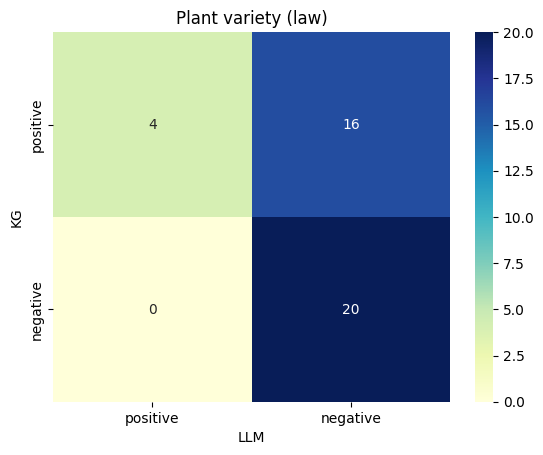

### LLM negative, KG positive

label,description,rationale
Hawkeye (ciruela),Hawkeye (ciruela),"The definition of Plant variety (law) states that it refers to a legal status of a cultivated plant that may not be propagated. The description of Hawkeye (ciruela) identifies it as a ""plum cultivar variety"". A cultivar is a plant variety that has been produced in cultivation by selective breeding. Therefore, given that Hawkeye (ciruela) is a cultivated plant variety, it fits within the definition of a Plant variety (law)."
African Rose,African Rose,"The definition of Plant variety (law) states that it is a legal status for a cultivated plant that may not be propagated. The description of African Rose indicates that it is a variety of plum that was obtained through a specific program in South Africa. This suggests that African Rose is a cultivated plant, and if it is legally protected from propagation, it would fit the definition of a Plant variety (law). Therefore, it can be argued that African Rose is a Plant variety (law)."
Prunus salicina 'Alhambra',Prunus salicina 'Alhambra',"The definition of a Plant variety (law) is a cultivated plant that may not be propagated. Prunus salicina 'Alhambra' is described as a plum cultivar. A cultivar is a plant variety that has been produced in cultivation by selective breeding. Therefore, it can be argued that Prunus salicina 'Alhambra' fits the definition of a Plant variety (law) as it is a cultivated plant. However, the information provided does not specify whether or not it may be propagated, which is a key part of the definition of Plant variety (law)."
Heron,Heron,"The definition of a Plant variety (law) is a cultivated plant that may not be propagated. The entity Heron is described as ""Prunus domestica"", which indicates that it is a type of plant. Therefore, if Heron is a cultivated plant and it is legally restricted from being propagated, it could be considered a Plant variety (law)."
Prunus domestica ʽJojo’,Prunus domestica ʽJojo’,"The definition of a Plant variety (law) is a legal status given to a cultivated plant that may not be propagated. The entity Prunus domestica ʽJojo’ is described as a plum cultivar. A cultivar is a plant variety that has been produced in cultivation by selective breeding. Therefore, given that Prunus domestica ʽJojo’ is a cultivated plant, it could potentially fall under the category of a Plant variety (law), assuming it has been granted this legal status and may not be propagated."
Prunus domestica ʽGraf Althans’,Prunus domestica ʽGraf Althans’,"The definition of Plant variety (law) states that it refers to a cultivated plant that may not be propagated. The entity Prunus domestica ʽGraf Althans’ is described as a ""plum cultivar"". A cultivar is a plant variety that has been produced in cultivation by selective breeding. Therefore, given that Prunus domestica ʽGraf Althans’ is a cultivated plant, it fits the definition of a Plant variety (law)."
Trinidad Moruga Scorpion,"Trinidad Moruga Scorpion: The Trinidad Moruga scorpion (a cultivar of Capsicum chinense) is a chili pepper native to the village of Moruga, Trinidad and Tobago. In 2012, New Mexico State University's Chile Pepper Institute identified the Trinidad Moruga scorpion as the hottest chili at that time, with heat of 1.2 million Scoville heat units (SHUs).By 2017 according to Guinness World Records, the hottest pepper was the Carolina Reaper, with 1.6 million SHU.","The definition of Plant variety (law) refers to a cultivated plant that may not be propagated. The Trinidad Moruga Scorpion is described as an exceptionally hot chili pepper, which indicates that it is a type of plant. Therefore, it could be argued that the Trinidad Moruga Scorpion is a Plant variety (law) if it is a cultivated plant that is legally protected from propagation. However, the provided information does not specify whether the Trinidad Moruga Scorpion is legally protected from propagation, so further information would be needed to confirm this asserti

## Seyfert galaxy (http://www.wikidata.org/entity/Q213930)

Seyfert galaxy: Seyfert galaxies are one of the two largest groups of active galaxies, along with quasars. They have quasar-like nuclei (very luminous sources of electromagnetic radiation that are outside of our own galaxy) with very high surface brightnesses whose spectra reveal strong, high-ionisation emission lines, but unlike quasars, their host galaxies are clearly detectable.Seyfert galaxies account for about 10% of all galaxies and are some of the most intensely studied objects in astronomy, as they are thought to be powered by the same phenomena that occur in quasars, although they are closer and less luminous than quasars. These galaxies have supermassive black holes at their centers which are surrounded by accretion discs of in-falling material. The accretion discs are believed to be the source of the observed ultraviolet radiation. Ultraviolet emission and absorption lines provide the best diagnostics for the composition of the surrounding material.Seen in visible light, most Seyfert galaxies look like normal spiral galaxies, but when studied under other wavelengths, it becomes clear that the luminosity of their cores is of comparable intensity to the luminosity of whole galaxies the size of the Milky Way.Seyfert galaxies are named after Carl Seyfert, who first described this class in 1943.



### Confusion matrix

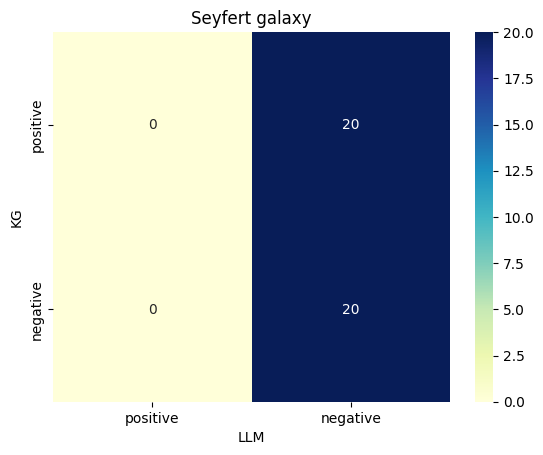

### LLM negative, KG positive

label,description,rationale
NGC 1672,"NGC 1672: NGC 1672 is a barred spiral galaxy located in the constellation Dorado. It was discovered by the astronomer James Dunlop on November 5, 1826. It was originally unclear whether it was a member of the Dorado Group, with some sources finding it to be a member and other sources rejecting its membership. However, recent tip of the red-giant branch (TRGB) measurements indicate that NGC 1672 is located at the same distance as other members, suggesting it is indeed a member of the Dorado Group.NGC 1672 has a large bar which is estimated to measure around 20 kpc. It has very strong radio emissions emanating from its nucleus, bar, and the inner portion of the spiral arm region. The nucleus is Seyfert type II and is engulfed by a starburst region. The strongest polarized emissions come from the northeastern region which is upstream from its dust lanes. Magnetic field lines are at large angles with respect to the bar and turn smoothly to the center.Two supernovae have been observed in NGC 1672: SN 2017gax (type Ib/c, mag. 14.1) and SN 2022aau (type II, mag. 16.3).","The provided definitions do not supply enough information to argue that NGC 1672 is a Seyfert galaxy. The definition of a Seyfert galaxy is simply stated as a ""class of galaxies,"" but does not provide specific characteristics or criteria that could be used to classify NGC 1672 as such. Similarly, the description of NGC 1672 as a ""barred spiral galaxy in the constellation Dorado"" does not provide any overlapping or relevant information that could link it to the Seyfert galaxy class. Therefore, based solely on the provided definitions, an argument cannot be made that NGC 1672 is a Seyfert galaxy."
Messier 77,"Messier 77: Messier 77 (M77), also known as NGC 1068 or the Squid Galaxy, is a barred spiral galaxy in the constellation Cetus. It is about 47 million light-years (14 Mpc) away from Earth. Messier 77 was discovered by Pierre Méchain in 1780, who originally described it as a nebula. Méchain then communicated his discovery to Charles Messier, who subsequently listed the object in his catalog. Both Messier and William Herschel described this galaxy as a star cluster. Today, however, the object is known to be a galaxy. The morphological classification of NGC 1068 in the De Vaucouleurs system is (R)SA(rs)b, where the '(R)' indicates an outer ring-like structure, 'SA' denotes a non-barred spiral, '(rs)' means a transitional inner ring/spiral structure, and 'b' says the spiral arms are moderately wound. Ann et al. (2015) gave it a class of SAa, suggesting tightly wound arms. However, infrared images of the inner part of the galaxy reveal a prominent bar not seen in visual light, and for this reason it is now considered a barred spiral.Messier 77 is an active galaxy with an active galactic nucleus (AGN), which is obscured from view by astronomical dust at visible wavelengths. The diameter of the molecular disk and hot plasma associated with the obscuring material was first measured at radio wavelengths by the VLBA and VLA. The hot dust around the nucleus was subsequently measured in the mid-infrared by the MIDI instrument at the VLTI. It is the brightest and one of the closest and best-studied type 2 Seyfert galaxies, forming a prototype of this class. X-ray source 1H 0244+001 in Cetus has been identified as Messier 77. Only one supernova has been detected in Messier 77. The supernova, named SN 2018ivc, was discovered on 24 November 2018 by the DLT40 Survey. It is a type II supernova, and at discovery it was 15th magnitude and brightening.In February 2022 the European Southern Observatory found a cloud of cosmic dust at the centre of Messier 77 hiding a supermassive black hole.In November 2022, the IceCube collaboration announced the detection of a neutrino source emitted by the active galactic nucleus of Messier 77. It is the second detection by IceCube after TXS 0506+056, and only the fourth known source including SN1987A and so

In [8]:
for experiment in experiment_df["experiment"].values:
    display_experiment(experiment)